In [22]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(janitor)
  library(tidymodels)
  library(repr)
  library(GGally)
  library(patchwork)
  library(cowplot)
})

# Predictive Modelling of Newsletter Subscription Among Minecraft Players: The Roles of Experience, Age, and Play-time

## Introduction

Understanding player engagement is a key component of game-related research and video-game analytics, as it allows researchers to identify how players interact with their platform. Newsletters not only function as a useful communication tool, but also provide an indirect indication of player engagement with the game and the company. This engagement is a valuable indicator of how appealing the game is from the player's perspective. When players choose to subscribe, it suggests that they are not only enjoying the game, but are also interested in ongoing development and future trajectories.

Thus, understanding the characteristics of players who choose to subscribe to a newsletter can be highly useful for game developers and marketing researchers. These insights can help clarify what drives player appeal and inform strategies that enhance user engagement, allowing future newsletters and communications to be better tailored to different player demographics.

In this project, we aim to investigate the following questions:

**Broad Question**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question**: Could experience, game-play time, and age predict whether or not an individual will subscribe to the Minecraft research newsletter in the player dataset?

As stated in our specific question, we selected the three following variables: experience, game-play time, and age as predictors. These metrics capture different features related to user engagement:
1) **Experience**: This variable reflects the user's skill level in the game. More experienced players may feel more invested in the game, and subsequently show more interest in ongoing research and game development. Thus, player experience may be a useful variable to predict subscription to a game-related newsletter.
2) **Game-play time**: Total game-play time is the most intuitive measure of player engagement. Individuals that spend more time playing the game may be more likely to show interest in game-related newsletters and updates.
3) **Age**: Age is a relevant demographic factor, because different age groups may have different incentives and motivations to play. Younger players may show less interest in reading news/updates, while older players may appreciate consistent progress updates, making age a potentially useful predictor for newsletter subscription. 

To answer these questions, we use the ```players.csv``` dataset. This data was collected by a computer science research group at UBC, who created a MineCraft server that collected data by recording each player's information, actions of their session, and duration of their session. This dataset is shown below, as well as a table describing all the variables:

In [23]:
players <- read_csv("players.csv") |>
clean_names() 
head(players)

summary(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashed_email        played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

**Players Data Set**: The players.csv data set describes data regarding individual players of the game. It has 196 observations with the 7 following variables: 
|Variable|Data Type|Description|
|---|---|---|
|**experience**|Character|Describes the players' experience with the game as either "Pro", "Veteran", "Regular", or "Amateur"|
|**subscribe**|Logical|Displays "TRUE" if the player is subscribed to the newsletter, and "FALSE" if they are not|
|**hashedEmail**|Character|The unique identification (privacy safe way of displaying email) of the player|
|**played_hours**|Double|Amount of time (hours) players played during all sessions|
|**name**|Character|Players' first name|
|**gender**|Character|Players' gender as "Female", "Male", "Agender", "Two Spirited", "Non-Binary", or "Prefer not to say"|
|**age**|Double|Players' age in years|



**Summary Statistics:**
|Variable |Min | Max | Mean  | Q1 | Q2 | Q3 |
|---------|----|-----|------|-----|----|----|
|played_hours (hrs)|0.00|223.10|5.85|0.00|0.10|0.60|
|age (years)|9.00|58.00|21.14|17.00|19.00|22.75|

Below are are some potential issues with this dataset:

- ```min_hours = 0```: some players registered but never played. This indicates that some data might be missing.
- ```max_hours = 223.1```: data is positively skewed. Subsequently, ```mean_hours``` may be inflated.
- Some players did not report ```Age```. This could lead to bias and reduces the effective sample size.

<h2>Methods and Results</h2>

The goal of predicting players' subscription status using the variables Age, Experience Level, and Hours Played from the "players.csv" dataset can be appropriately performed through KNN Classification. Because the outcome of our predictive question - whether a player will subscribe to the Minecraft Research Newsletter - is binary (TRUE or FALSE), our chosen response variable is categorical. Hence, the KNN classification model is a useful approach to address this question as it makes no assumptions about the distribution of our data, which is helpful given the lack of visible relationships among the three predictors. 

<h4>Visualizations</h4>
First, to examine our chosen variables, summary plots are generated:

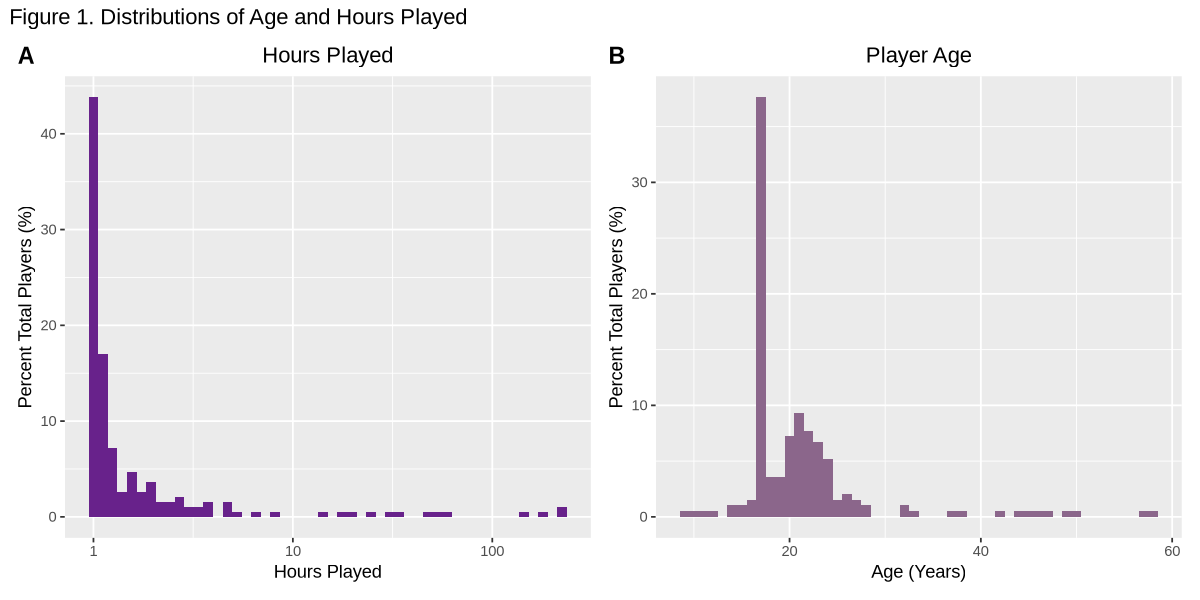

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


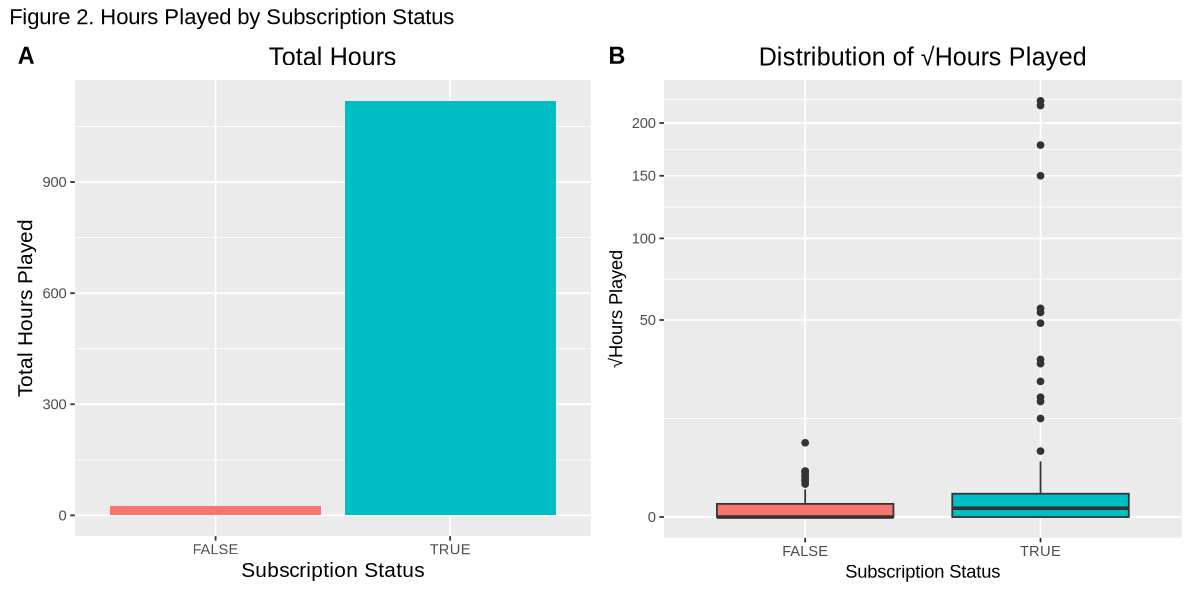

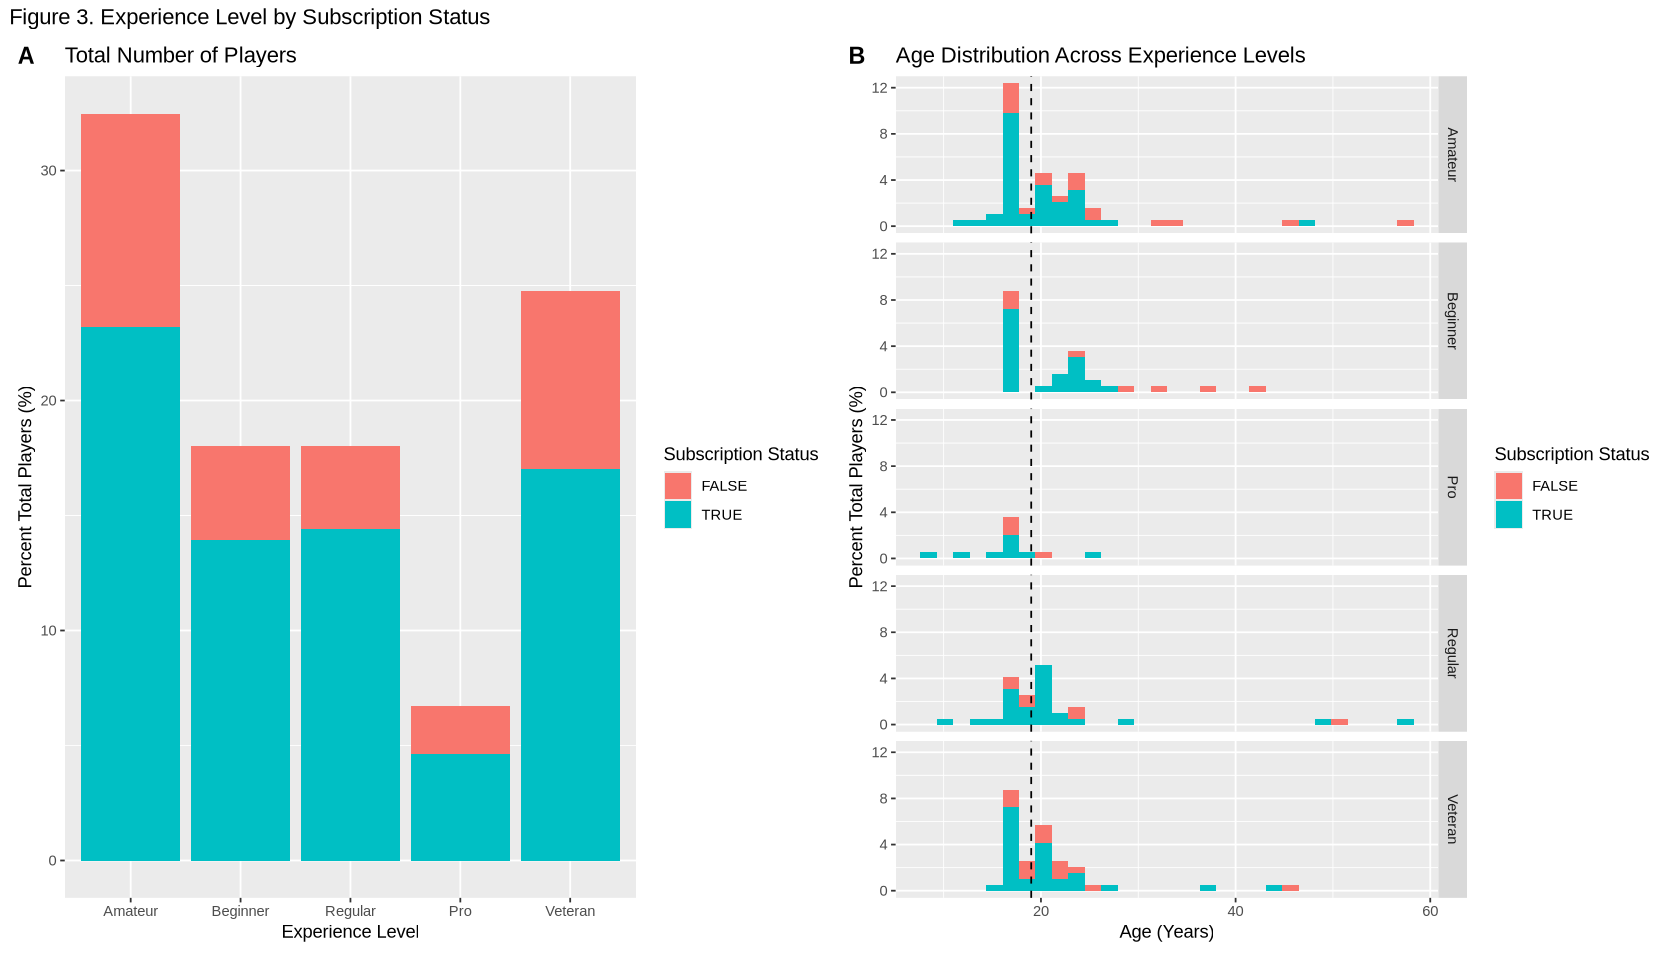

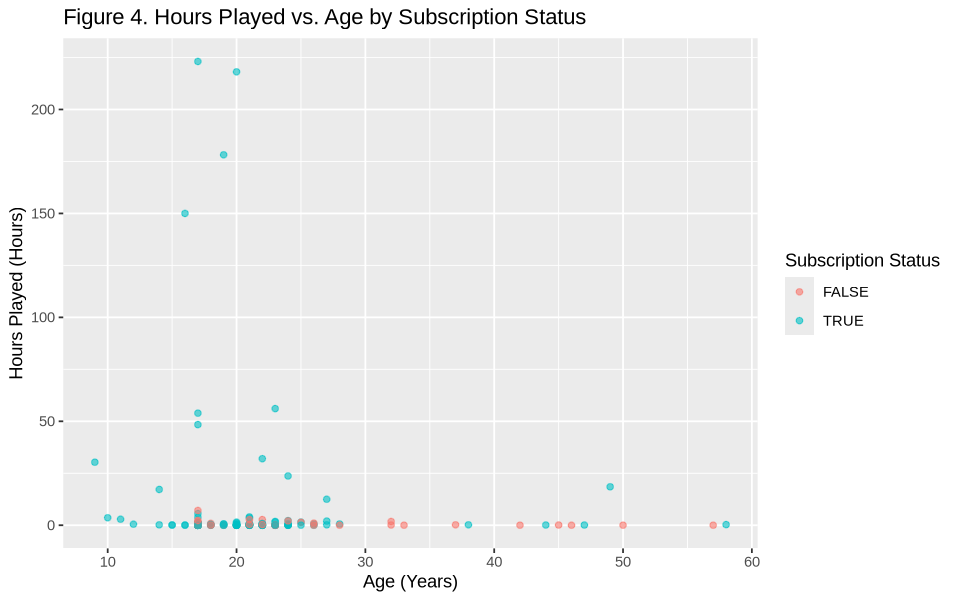

In [28]:
options(repr.plot.width = 10, repr.plot.height = 5)

## Figure 1A: create histogram of hours played per player
hours_hist <- players |>
    ggplot(aes(x = played_hours + 1)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'darkorchid4') +
    labs(title = 'Hours Played',
         x = 'Hours Played',
         y = 'Percent Total Players (%)') +
    scale_x_log10() +
    theme(plot.title = element_text(hjust = 0.5))


## Figure 1B: create histogram of players' ages
age_hist <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'plum4') +
    labs(title = 'Player Age',
         x = 'Age (Years)',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))

## FIGURE 1. 
plot_grid(hours_hist, age_hist, labels="AUTO") + 
plot_annotation(title = 'Figure 1. Distributions of Age and Hours Played') 


## Figure 2A: create bar charts
sub_hours_bar <- players |>
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Hours",
         x = "Subscription Status", 
         y = "Total Hours Played") +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
          axis.title = element_text(size = 12.5),
         legend.position = 'none')

## Figure 2B: create box plot
sub_hours_box <- players |> 
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_boxplot() +
    labs(title = "Distribution of √Hours Played",
         x = "Subscription Status", 
         y = '√Hours Played') + 
    scale_y_sqrt() +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
         legend.position = "none")

## FIGURE 2. 
plot_grid(sub_hours_bar, sub_hours_box, labels="AUTO") + 
plot_annotation(title = 'Figure 2. Hours Played by Subscription Status')


options(repr.plot.width = 14, repr.plot.height = 8)

## Figure 3A: Experience bar chart
experience_bar <- players |>
    ggplot(aes(x = factor(experience,levels = c("Amateur", "Beginner", "Regular", "Pro", "Veteran")) , fill = subscribe)) +
    geom_bar(aes(y = after_stat(count/sum(count) * 100))) +
    xlab("Experience Level") +
    ylab("Percent Total Players (%)") +
    ggtitle("Total Number of Players") +
    labs(fill = "Subscription Status")

age_distribution <- players |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(aes(y = after_stat(count/sum(count) * 100))) +
    facet_grid(rows = vars(experience)) +
    xlab("Age (Years)") +
    ylab("Percent Total Players (%)") +
    ggtitle("Age Distribution Across Experience Levels") +
    labs(fill = "Subscription Status") +
    geom_vline(xintercept = 19, linetype = "dashed")

plot_grid(experience_bar, age_distribution, labels="AUTO") + 
plot_annotation(title = 'Figure 3. Experience Level by Subscription Status')


options(repr.plot.width = 8, repr.plot.height = 5)

## create plot of hours played vs age, group by subscription status
age_hours_plot <- players |> 
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) + 
    labs(title = 'Figure 4. Hours Played vs. Age by Subscription Status', 
         x = 'Age (Years)',
         y = 'Hours Played',
        color = 'Subscription Status')
age_hours_plot




**Figure 1** hows us that a majority of the players tend to play for 1 - 3 hours, and are between approximately 18 to 25 years of age. This suggests that player age and playing hours may be good predictors of subscription, as there is a clear age group and group of individuals that play a certain amount of hours that tend to make up most of the total players. 

- **Figure 1A**: The y-axis is log10 transformed which helps us visualize the extremely right-skewed distribution - a large proportion (>40%) of total players are in the lowest bin, and very few players with very high play-time.  
- **Figure 1B**: Player age ranges from 9-58 years. The largest bin is ~17-19 years, and the distribution has a moderate right skew. Overall, the game is mostly played by young adults.

**Figure 2** is similar in that it shows players with higher than normal play times are almost always subscribed, and players who are not subscribed have lower playing hours. Once again, this suggests that played hours may be a good predictor of subscription status. We see a trend in subscribed players having higher played hours and players that are not subscribed tend to have lower playing hours.

- **Figure 2A**: Total hours played is much higher in subscribers than non-subscribers.
- **Figure 2B**: A square root transformation was applied to help reduce the skew, and better visualize the distribution. Subscribers have a slightly higher median, and more extreme values compared to non-subscribers.

**Figure 3** does not display any apparent relationship between experience level and subscription status. All experience levels appear to have proportional numbers of players who subscribed and did not subscribe.  

- **Figure 3A**: The proportion of players, grouped by subscription status, in each experience level. Amateur players make up over 30% of players, with the next largest group being Veteran players. Pro players make up less than 10% of total players.
- **Figure 3B**: Age distributions are shown, split by experience level. The median age across all levels is shown by the dashed line.

**Figure 4** shows the relationship between hours played and player age, grouped by subscription status. Most players (regardless of age) have a low play time. There are more extreme values among younger players. Overall, there is no clear clustering between subscribed and non-subscribed players by age. 


<h4>Creating The Model</h4>

The KNN model is trained using age, experience, and played hours. To begin analysis, we selected our desired variables and removed all missing observations. We split the "players" dataset into training (75%) and testing (25%) sets through stratified sampling and standardized all numeric variables prior to modelling. 


To apply this model, assumptions include:
- The sample size is large enough to reliably train the model
- The response variable is categorical
- Player behaviours/observations are all independent of each other

A potential limitations is that the dataset is relatively small, so it may not be truly be generalizable to new players. We address this as one the assumptions above.  

To prepare for classfication, we tuned the KNN model by choosing 20 different values of of nearest neighbours (k) and performed five-fold cross validation on the training set to obtain the highest accuracy parameter. A visualization of the best K value is provided and we identified the highest accuracy value through the accuracy metric. 

[1] 7

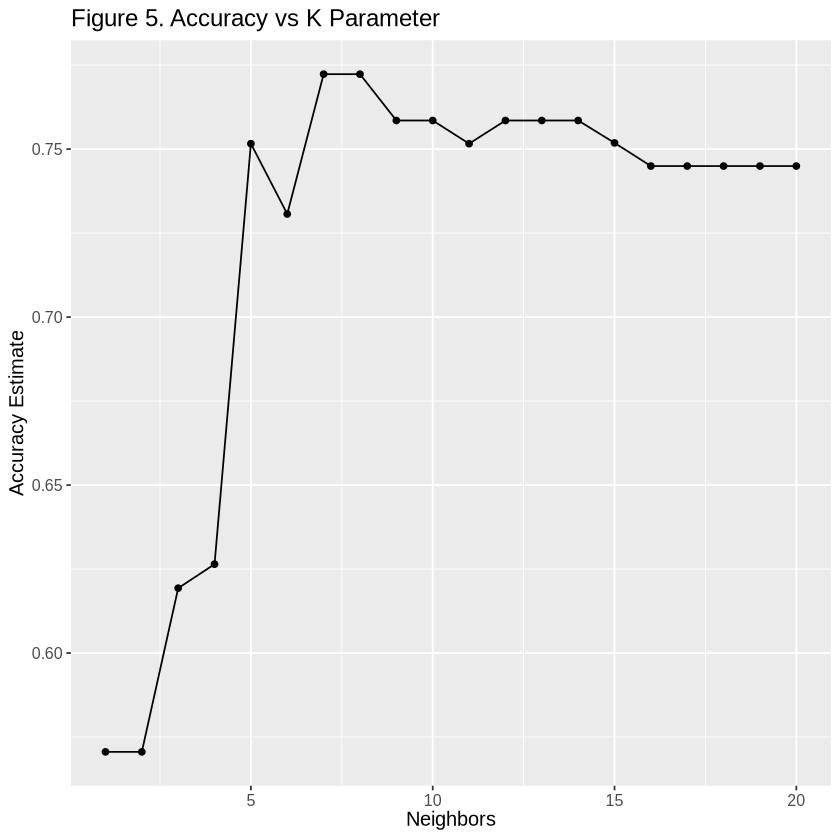

In [29]:
set.seed(2024)

players <- players |>
    select(subscribe, age, experience, played_hours) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()  # removes rows with missing values
      
#splitting data
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#model k-classification
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#model recipe
players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
            step_zv(all_predictors()) |>
            step_scale(all_numeric_predictors()) |>
            step_center(all_numeric_predictors())

#folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)



#values of k
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#workflow results
knn_results <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(knn_tune_spec) |>
                 tune_grid(resamples = players_vfold, grid = k_vals) |>
                 collect_metrics()

#determine the accuracy 
accuracies <- knn_results |>
                  filter(.metric == 'accuracy') |>
                  select(neighbors, mean)

#Visualizing K parameter and accuracy
options(repr.plot.height = 7, repr.plot.width = 7)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure 5. Accuracy vs K Parameter") +
  theme(text = element_text(size = 12))
accuracy_vs_k

#determines best K value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

**Figure 5** shows the KNN model's accuracy estimate across the different values for the K parameter. We can see a steep increase in accuracy up to around K = 7, where it reaches its highest value. Thus, our optimal number of neighbours is K = 7. After this value, the slope of the graph decreases and stabilizes. This shows us that very small K values tend to overfit the data (poor accuracy), while large K values may start to underfit. The plateau observed at K = 16 and beyond indicates that increasing K further does not improve model performance, and the model no longer captures any meaningful structure in the dataset. 

<h4>Testing The Model</h4>

After identifying the optimal number of neighbours (7), we fit the KNN model to the full training set and finalized its accuracy by using the model generate predictions on the testing dataset. We evaluated the classifier by calculating its accuracy, precision, and recall, and produced a confusion matrix to show the number of correct and incorrect predictions.

In [30]:
set.seed(2024)


#model k-classification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
            set_engine("kknn") |>
            set_mode("classification")
players_spec

#knn fit
players_fit <- workflow() |>
            add_recipe(players_recipe) |>
            add_model(players_spec) |>
            fit(data = players_train)
players_fit
                                

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_zv()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2206897
Best kernel: rectangular
Best k: 7

In [33]:
set.seed(2024)


#fitting it to testing 
players_test_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)


#testing its accuracy 
players_prediction_accuracy <- players_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)             

players_prediction_accuracy


#players matrix 
players_mat <-  players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

players_mat



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.61224490
kap,binary,-0.07381776


          Truth
Prediction FALSE TRUE
     FALSE     2    8
     TRUE     11   28

## Observations 

In `players_mat`, 30 observations were labelled correctly, and 19 observations were labelled incorrectly. 

The **precision** of our positive classifier is 0.7179 (```precision_true```)

The **recall** of our positive classifier is 0.7778 (```recall```)

In [34]:
precision_true <- 28/(11+28)
precision_true

recall <- 28/(8 + 28)
recall

[1] 0.7179487

[1] 0.7777778

|Accuracy|Precision|Recall|
|---|---|---|
0.6122|0.7179|0.7778|

Our accuracy, precision, and recall will tell us how well our classifier is preforming:
- **Accuracy:** An accuracy of 0.6122, which tells us 61.22% of the predictions were correct.
- **Precision:** Precision tells us how many of the observations classified as subscribed were actually subscribed. This means 71.79% of the observations classified as true are correct.
- **Recall:** Recall tells us the amount of actually true observations were classified as true. This means 77.78% of observations that were subscribed were classified as subscribed. 

## Discussion

The classifer achieved an **accuracy of 61.22%**, a **precision of 71.79%**, and a **recall of 77.78%**. This accuracy value suggests that our model makes correct predictions over half of the time, while the recall and precision values indicates that the model is better at identifying positive cases. This is consistent with our expectations, as we anticipated that the model is more effective in correctly predicting subscribed cases given the distribution of class in the dataset (where the majority of players are subscribed). 

These results indicate that the trained KNN classification model is moderately useful in predicting the newsletter subscription of players. While the performance is not very high, it suggests that the chosen predictors do somewhat influence subscription status. The moderate performance may also be an indication of more complex relationships influencing subscription status. These findings allow game developers to gain insights into specific player demographics, such as whether or not younger players with high playtime are more likely to subscribe. However, since the model only achieves an overall accuracy is ~61%, misclassifications can also occur - meaning that the model may overlook potential subscribers that do not necessarily fit within a particular demographic.

As our model only used 3 predictors, these results can raise additional questions. A potential follow-up investigation could determine if other variables, such as gender, could improve the model's prediction accuracy. This also raises the broader question of whether adding more predictors truly influences performance, or whether a limited set of specific chosen predictors is more effective. It would also be interesting to investigate how long it takes for a player to subscribe after they begin playing. Examining differences between players who subscribe and those who never subscribe could highlight potential variables to include in future models. For instance, non-subscribing players may differ in play style, session frequency, or in-game achievements compared to those who eventually subscribe. However, these behavioural variables are not included in the current dataset and would require further data collection.

Another question would be whether an alternative model (beyond those we have covered in class) might perform better than KNN on this dataset. It would be interesting to conduct a broader meta-analysis of model performance by comparing KNN to other classification algorithms (macro-level comparison), and then explore deeper hyperparameter tuning within each model (micro-level analysis) to determine the most effective approach.

Overall, our KNN model shows that experience, play-time, and age offer some predictive value for newsletter subscription. However, the moderate accuracy suggests that additional variables (likely not captured in this model or dataset) also play an important role. These findings provide a starting point for understanding player engagement patterns, while highlighting the need for further data collection and analysis.